# RAG in Pixeltable

In this tutorial, we'll demonstrate how RAG operations can be implemented in Pixeltable. In particular, we'll develop a RAG application that summarizes a collection of PDF documents and uses ChatGPT to answer questions about them.

In a traditional RAG workflow, such operations might be implemented as a Python script that runs on a periodic schedule or in response to certain events. In Pixeltable, as with everything else, they are implemented as persistent table operations that update incrementally as new data becomes available.

We'll begin by setting up our environment (and removing any stale tables from previous runs of the demo).

In [2]:
from pathlib import Path
import numpy as np
import pixeltable as pxt

data_dir = Path('~/Downloads/Documents_Questions').expanduser()
pxt.create_dir('rag_demo', ignore_errors=True)
pxt.drop_table('rag_demo.chunks', ignore_errors=True)
pxt.drop_table('rag_demo.documents', ignore_errors=True)
pxt.drop_table('rag_demo.queries', ignore_errors=True, force=True)

Next we'll create a table containing the sample questions we want to answer. The questions are stored in an Excel spreadsheet, along with a set of "ground truth" answers to help evaluate our model pipeline. We can use Pixeltable's handy `import_excel` tool to load them.

In [2]:
queries_t = pxt.io.import_excel('rag_demo.queries', data_dir / 'Ques_Ans.xlsx')
queries_t.show()

Created table `queries`.
Inserting rows into `queries`: 41 rows [00:00, 10152.70 rows/s]
Inserted 41 rows with 0 errors.


S__No_,Question,correct_answer
1,What is JPMorgan's net income for the second quarter of 2023 ?,$14.5 Billion
2,What JPMorgan's net income per share for second quarter of 2023 ?,$4.75 per share
3,What is the change in JPMorgan debit and credit card sales volume for second quarter of 2023?,The sales volume was up by 7 %
4,What was the net revenue reported for 2Q23 for JPMorgan Chase?,"$41, 307 Million"
5,What was the net revenue reported for 2Q23 for JPM?,"$41, 307 Million"
6,What was the net revenue reported for second quarter of 2023 for JPM?,"$41, 307 Million"
7,What was the net income for the second quarter of 2023 for JP Morgan Asset & Wealth Management?,$ 1226 million
8,What was the net income for the 2Q23 for JPM Asset and Wealth Management (AWM)?,$ 1226 million
9,What is JP Morgan's banking and asset management net revenue for second quarter of 2023?,$10.9 Billion up 68%
10,What is Shopify's 2020 Revenue?,$2.9 Billion


## The Plan

There are two major components to our RAG application:

1. Document Indexing: Load the documents, split them into chunks, and index them using a vector embedding.
2. Querying: For each question on our list, do a top-k lookup for the most relevant chunks, use them to construct a ChatGPT prompt, and send the enriched prompt to an LLM.

We'll implement both pieces in Pixeltable.

## 1. Document Indexing

All data in Pixeltable, including documents, resides in tables.

Tables are persistent containers that can serve as the store of record for your data. Since we are starting from scratch, we will start with an empty table `rag_demo.documents` with a single column, `document`.

In [3]:
documents_t = pxt.create_table('rag_demo.documents', {'document': pxt.DocumentType()})
documents_t

Created table `documents`.


Column Name,Type,Computed With
document,document,


Next, we'll insert our first few source documents into the new table.

Inserting rows into `documents`: 4 rows [00:00, 2559.06 rows/s]
Inserted 4 rows with 0 errors.


document
""
""
""
""

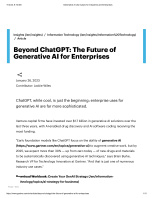
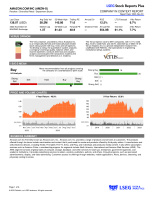
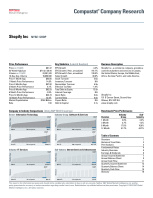
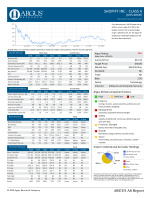

In [4]:
document_files = [str(path) for path in data_dir.glob('*.pdf')]
documents_t.insert({'document': doc} for doc in document_files[:4])
documents_t.show()

In RAG applications, we often decompose documents into smaller units, or chunks, rather than treating each document as a single entity. In this example, we'll use Pixeltable's built-in `DocumentSplitter`, but in general the chunking methodology is highly customizable. `DocumentSplitter` has a variety of options for controlling the chunking behavior, and it's also possible to replace it entirely with a user-defined iterator (or an adapter for a third-party document splitter).

In Pixeltable, operations such as chunking can be automated by creating _views_ of the base `documents` table. A view is a virtual derived table: rather than adding data directly to the view, we define it via a computation over the base table. In this example, the view is defined by iteration over the chunks of a `DocumentSplitter`.

In [5]:
from pixeltable.iterators import DocumentSplitter

chunks_t = pxt.create_view(
    'rag_demo.chunks',
    documents_t,
    iterator=DocumentSplitter.create(document=documents_t.document, separators='token_limit', limit=300)
)
chunks_t

Inserting rows into `chunks`: 103 rows [00:00, 20093.64 rows/s]
Created view `chunks` with 103 rows, 0 exceptions.


Column Name,Type,Computed With
pos,int,
text,string,
document,document,


Notice that as soon as we created it, `chunks` was automatically populated with data from the existing documents in our base table. We can select the first 2 chunks from each document using common dataframe operations, in order to get a feel for what was extracted:

pos,text,document
0,"11/4/23, 9:10 AM\nGenerative AI Use Cases for Industries and Enterprises\nhttps://www.gartner.com/en/articles/beyond-chatgpt-the-future-of-generative-ai-for-enterprises\n1/11\nInsights (/en/insights) / Information Technology (/en/insights/Information%20Technology)\n/ Article\nBeyond ChatGPT: The Future of\nGenerative AI for Enterprises\nChatGPT, while cool, is just the beginning; enterprise uses for\ngenerative AI are far more sophisticated.\n\nJanuary 26, 2023\nContributor: Jackie Wiles\nVenture capital firms have invested over $1.7 billion in generative AI solutions over the\nlast three years, with AI-enabled drug discovery and AI software coding receiving the\nmost funding. \n""Early foundation models like ChatGPT focus on the ability of generative AI\n(https://www.gartner.com/en/topics/generative-ai) to augment creative work, but by\n2025, we expect more than 30% — up from zero today — of new drugs and materials\nto be systematically discovered using generative AI techniques,"" says Brian Burke,\nResearch VP for Technology Innovation at Gartner. ""And that is just one of numerous\nindustry use cases.""\nDownload Workbook: Create Your GenAI Strategy (/en/information-\ntechnology/topics/ai-strategy-for-business)\nPrivacy - Terms\n11",
1,"/4/23, 9:10 AM\nGenerative AI Use Cases for Industries and Enterprises\nhttps://www.gartner.com/en/articles/beyond-chatgpt-the-future-of-generative-ai-for-enterprises\n2/11\nFive industry use cases for generative AI\nGenerative AI can explore many possible designs of an object to find the right or most\nsuitable match. It not only augments and accelerates design in many fields, it also has\nthe potential to ""invent"" novel designs or objects that humans may have missed\notherwise. \nMarketing and media are already feeling the impacts of generative AI. Gartner\nexpects:\nBy 2025, 30% of outbound marketing messages from large organizations will be\nsynthetically generated, up from less than 2% in 2022. \nBy 2030, a major blockbuster film will be released with 90% of the film generated\nby AI (from text to video), from 0% of such in 2022.\nStill, AI innovations (/en/articles/what-s-new-in-artificial-intelligence-from-the-\n2023-gartner-hype-cycle) are generally accelerating, creating numerous use cases\nfor generative AI in various industries, including the following five.\nNo. 1: Generative AI in drug design\nA 2010 study showed the average cost of taking a drug from discovery to market was\nabout $1.8 billion, of",
0,"Last Close\n138.07 (USD)\n2023 November 02\nNASDAQ Exchange\nAvg Daily Vol\n58.2M\n52-Week High\n145.86\nTrailing PE\n71.6\nAnnual Div\n--\nROE\n12.5%\nLTG Forecast\n--\n1-Mo Return\n6.7%\nMarket Cap\n1.3T\n52-Week Low\n81.43\nForward PE\n48.9\nDividend Yield\n--\nAnnual Rev\n554.0B\nInst Own\n61.1%\n3-Mo Return\n7.7%\nVERUS OPINION\nBuy\nThe Verus Opinion, provided by Verus Analytics Inc,\nis an empirically-derived and historically back-tested\nstock rating system with buy, hold, and sell opinions.\nTo develop a rating, the quantitative system analyzes\na company's earnings quality, balance sheet, and\nincome statement, conducts technical and valuation\nanalysis and evaluates the transactions made by the\nfirm's management and directors (i.e. insiders).\nThe Verus Opinion covers 4591 companies, with 12.1% rated\nBuy, 64.3% rated Hold, and 23.5% rated Sell as of 2023-10-27.\nVerus Analytics Inc is a private independent research firm,\nunaffiliated with Refinitiv, that specializes in engineering\ninstitutional ratings systems.\nI/B/E/S MEAN\nBuy\nMean recommendation from",
1,"all analysts covering\nthe company on a standardized 5-point scale.\n54 Analysts\nStrong\nSell\nSell\nHold\nBuy\nStrong\nBuy\nStrong Buy\nBuy\nHold\nSell\nStrong Sell\n18\n35\n1\n0\n0\nPRICE AND VOLUME CHARTS\n1-Year Return: 49.9%\n5-Year Return: 65.8%\nBUSINESS SUMMARY\nAmazon.com Inc Formerly known as Amazon.com, Inc.. Amazon.com, Inc. provides a range of products and services to cus
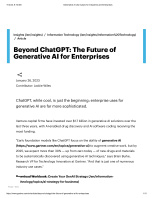
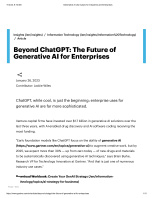
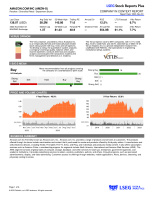
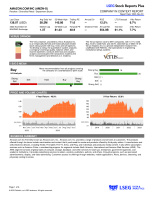
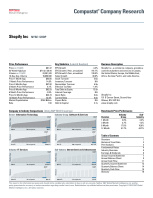
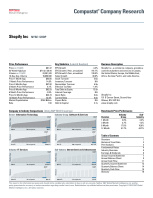
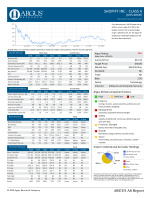
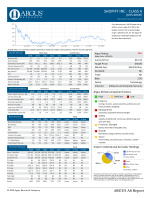

In [6]:
chunks_t.where(chunks_t.pos < 2).show()

Now let's compute vector embeddings for the document chunks and store them in a vector index. Pixeltable has built-in support for a variety of vector embeddings, and it's easy for users to add new ones via UDFs. In this demo, we're going to use the E5 model from the Huggingface `sentence_transformers` library, which runs on a local GPU.

The following command attaches the E5 model as an index to the `text` column in the `chunks` table. Note that as soon as we define the index, Pixeltable automatically updates the table by indexing all existing rows.

In [7]:
from pixeltable.functions.huggingface import sentence_transformer

@pxt.expr_udf
def e5_embed(text: str) -> np.ndarray:
    return sentence_transformer(text, model_id='intfloat/e5-large-v2')

chunks_t.add_embedding_index('text', text_embed=e5_embed)

Computing cells: 100%|████████████████████████████████████████| 103/103 [00:07<00:00, 14.02 cells/s]


This completes the first part of our application, Document Indexing. Now it's time to run some queries!

## 2. Querying

In order to express a top-k lookup against our index, we use Pixeltable's `similarity` operator, packaged into standard `order_by` and `limit` operations. Before building this into our application, let's run a sample query to make sure it works.

In [8]:
query_text = "What is JPMorgan's net income for the second quarter of 2023?"
top_5_chunks = (
    chunks_t.order_by(chunks_t.text.similarity(query_text), asc=False)
        .select(similarity=chunks_t.text.similarity(query_text), text=chunks_t.text)
        .limit(5)
    )
top_5_chunks.collect()

similarity,text
0.806538,"Research\nNov. 4, 2023\nCopyright ©2023 S&P Global Market Intelligence Inc. All rights reserved.\n12\nQuarterly Income Statement\nChange vs. Previous Year\nChart of Gross Profit (Loss) \n+ 14.9%\n– 8.5%\n+ 2.7%\n+ 2.4%\n+ 20.0%\n– 9.9%\n+ 14.5%\n600\n800\nMillions of $US\n6/30/23\n3/31/23\n12/31/22\n9/30/22\n6/30/22\n3/31/22\n12/31/21\n9/30/21\nQuarter Ending on\n$1,694\n$1,508\n$1,735\n$1,366\n$1,295\n$1,204\n$1,380\n$1,124\n \nSales/Turnover (Net) \n842\n764\n909\n678\n623\n550\n666\n502\n \nCost of Goods Sold\n852\n744\n826\n688\n672\n654\n714\n622\n \nGross Profit (Loss) \n817\n908\n985\n1,006\n846\n737\n678\n582\n \nSelling, General and Administrative Expenses\n35\n(164)\n(159)\n(318)\n(175)\n(83)\n37\n40\n \nOperating Income Before Depreciation\n18\n29"
0.796639,"\n2023-06-30\n0.650\n0.350\n85.7%\nPositive\n2023-04-27\n2023-03-31\n0.310\n0.212\n46.2%\nNegative\n2023-02-02\n2022-12-31\n0.030\n0.175\n-82.9%\nPositive\n2022-10-27\n2022-09-30\n0.280\n0.215\n30.2%\nNegative\n2022-07-28\n2022-06-30\n-0.200\n0.144\n-239%\nSurprise Summary (Last 12 Quarters)\nSurprise Type\nAmount\nPercent\nPositive Quarters (> 2%)\n8\n66.7%\nNegative Quarters (< -2%)\n4\n33.3%\nIn-Line Quarters (within 2%)\n0\n--\nANNUAL REVENUE\nA pattern of increasing sales in\nconjunction with a rising EPS may\ninfluence a buy recommendation, while\nflat or falling sales and faltering\nearnings may explain a sell\nrecommendation. A rising EPS with flat\nor falling sales may result from\nincreased cost efficiency and margins,\nrather than market expansion. This\nchart shows the sales forecast trend of\nall analysts and the highest and lowest\nprojections for the current and next\nfiscal year.\n700B\n650B"
0.795032,"\n600B\n550B\n500B\n450B\n2021\n2022\n2023\n2024\nActuals\nEstimates\n469.8B\n514.0B\nMEAN\nHIGH\nLOW\n2023\n2024\nMean\n570.5B\n635.2B\nHigh\n572.2B\n647.1B\nLow\n564.8B\n601.3B\nForecasted Growth\n11.0%\n23.6%\n# of Analysts\n39\n38\nFUNDAMENTAL HIGHLIGHTS\n-\nThe company's gross margin has been higher than its industry\naverage for each of the past five years.\n-\nThe company's days sales in receivables has been higher than its\nindustry average for each of the past five years.\n-\nThe company's interest coverage has been higher than its industry\naverage for each of the past five years.\n-\nAmazon.com Inc does not currently pay a dividend. Of 25 firms within\nthe Department Stores industry, it is among the 18 companies without\na dividend.\nFUNDAMENTAL METRICS\nProfitability\nAMZN\nIndustry\nAvg\nRevenue Growth\n10.3%\n5.1%\nFor year over year\nending 2023-09\nGross Margin\n46.2%\n39.3%\nFor latest 12 months\nending 2023-09\nReturn on Equity\n12.5%\n6.7"
0.793550,"+ 18.0%\n+ 657.3%\n+ 501.8%\n+ 18.7%\nNot Meaningful\n0\n250\n500\nMillions of $US\n2022\n2021\n2020\n2019\n2018\n2017\n2016\n2015\nOPERATING ACTIVITIES\n($3,460)\n$2,915\n$320\n($125)\n($65)\n($40)\n($35)\n($19)\n \nIncome Before Extraordinary Items\n93\n69\n79\n36\n27\n23\n14\n7\n \nDepreciation and Amortization\n(187)\n191\n(42)\n(38)\n0\n0\n0\n0\n \nDeferred Taxes\n3,516\n(2,509)\n169\n178\n103\n50\n22\n10\n \nFunds from Operations - Other excluding Option Tax Benefit\n3,516\n(2,509)\n169\n178\n103\n50\n22\n10\n \nFunds from Operations - Other\n(128)\n(338)\n(142)\n(130)\n(83)\n(51)\n(14)\n1\n \nAccounts Receivable - Decrease (Increase) \n37\n138\n119\n85\n21\n15\n20\n11\n \nAccounts Payable and Accrued Liabilities - Increase (Decrease) \nCF\nCF\nCF\nCF\n0\n0\n0\n0\n \nIncome Taxes - Accrued - Increase"
0.792514,"\n23-12\n24-03\nActuals\nEstimates\n0.030\n0.310\n0.650\n0.940\nMEAN\nHIGH\nLOW\nQuarterly\n23-12\n24-03\nMean\n0.767\n0.674\nHigh\n1.000\n1.040\nLow\n0.570\n0.360\n# of Analysts\n33\n19\n8.000\n6.000\n4.000\n2.000\n0.000\n-2.000\n2021\n2022\n2023\n2024\nActuals\nEstimates\n3.241\n-0.270\nMEAN\nHIGH\nLOW\nAnnual\n2023\n2024\nMean\n2.664\n3.510\nHigh\n2.900\n4.580\nLow\n2.470\n2.330\n# of Analysts\n39\n39\nAMAZON.COM INC (AMZN-O)\nRetailers / Dive

Great. Looks plausible! Let's build this into our pipeline via a computed column on the `queries` table. In this case, our computed column is a more complex operation: top-k similarity lookup against the data in the `chunks` table. To implement this operation, we'll use Pixeltable's `@query` decorator to enhance the capabilities of the `chunks` table.

In [9]:
# A @query is essentially a reusable select statement, defining a
# modular way of extracting content from a Table.

@chunks_t.query
def top_k(query_text: str):
    return (
        chunks_t.order_by(chunks_t.text.similarity(query_text), asc=False)
            .select(chunks_t.text, sim=chunks_t.text.similarity(query_text))
            .limit(5)
    )

# Now add a computed column to `queries_t`, calling the stored query
# `chunks_t.top_k` that we just defined.
queries_t['question_context'] = chunks_t.top_k(queries_t.Question)

Computing cells: 100%|██████████████████████████████████████████| 41/41 [00:05<00:00,  7.62 cells/s]
Added 41 column values with 0 errors.


Let's see what the results of the new query on our questions.

In [10]:
queries_t.select(queries_t.Question, queries_t.question_context).collect()

Question  \
0   What is JPMorgan's net income for the second q...   
1                     What is Shopify's 2020 Revenue?   
2   What JPMorgan's net income per share for secon...   
3   What is the change in JPMorgan debit and credi...   
4   What was the net revenue reported for 2Q23 for...   
5   What was the net revenue reported for 2Q23 for...   
6   What was the net revenue reported for second q...   
7   What was the net income for the second quarter...   
8   What was the net income for the 2Q23 for JPM A...   
9   What is JP Morgan's banking and asset manageme...   
10               What is shopify's 2021 gross margin?   
11             What is shopify's total debt for 2019?   
12  What are the key communication equipments sect...   
13         What was the ARGUS rating for SYNOPSYS INC   
14  What was the average market capitalization for...   
15    What is Shopify's 2015 Price to earnings ratio?   
16    What is  the market capitalization for Infosys?   
17  What is the revenue for thoughtworks holding inc?   
18  What is the Martello Technolofoes group annual...   
19               What is the stock rating for Amazon?   
20        What is the Market Capitatization for AMZN?   
21  What is the average market capitalization for ...   
22                What is the 1 year return for HEPS?   
23  What is the predicted earnings per share for A...   
24    What are the fundamental highlights for AMAZON?   
25  How many parameters were present in the Tiny M...   
26  What is the SOTA Word Error Rate in the LibriS...   
27  What is whisper's performance in language iden...   
28  What is the market cap for shopify for the yea...   
29  What is the financial Condition for shopify me...   
30  What was the compound annual growth in the tot...   
31  What is the source for the discussion on growt...   
32             Define technical automation potential    
33  Why have  technology adoption scenarios accele...   
34  How many hours in a day do knowledge workers s...   
35  What is the expected increase in sales product...   
36  What is the average cost of taking a drug from...   
37                            What is inverse design?   
38                            What is synthetic data?   
39  What are the threats associated with Generativ...   
40  What do transformer models use the mathematica...   

                                     question_context  
0   [{'sim': 0.8065378194932183, 'text': ' Researc...  
1   [{'sim': 0.8383171711847641, 'text': '
Busines...  
2   [{'sim': 0.8092374078121208, 'text': ' Researc...  
3   [{'sim': 0.8203609723175445, 'text': '
2023-06...  
4   [{'sim': 0.7939132092569239, 'text': ' Researc...  
5   [{'sim': 0.7911287781932589, 'text': ' Researc...  
6   [{'sim': 0.801091325380623, 'text': ' Research...  
7   [{'sim': 0.8012491703405733, 'text': ' Researc...  
8   [{'sim': 0.8063059093447305, 'text': ' of
whic...  
9   [{'sim': 0.8031765461914706, 'text': ' Researc...  
10  [{'sim': 0.8462573289871216, 'text': ' Margin ...  
11  [{'sim': 0.8260983228683472, 'text': '
140.0
1...  
12  [{'sim': 0.8060123920440674, 'text': 'OLD
CDNS...  
13  [{'sim': 0.8691135048866272, 'text': ' Healthy...  
14  [{'sim': 0.8406787169181922, 'text': 'Shopify ...  
15  [{'sim': 0.85418701171875, 'text': 'Shopify In...  
16  [{'sim': 0.7958451631161487, 'text': '%
4,000%...  
17  [{'sim': 0.8080144765381363, 'text': '1
-89.2
...  
18  [{'sim': 0.8227868781812874, 'text': '29
-0.29...  
19  [{'sim': 0.8255201086091946, 'text': ' all ana...  
20  [{'sim': 0.8245655998846546, 'text': '%
For in...  
21  [{'sim': 0.8248766660690308, 'text': '
2.03M
2...  
22  [{'sim': 0.7909836408789054, 'text': ' obtaine...  
23  [{'sim': 0.8343159457633478, 'text': '
600B
55...  
24  [{'sim': 0.8184217702401754, 'text': '
600B
55...  
25  [{'sim': 0.7468865664668951, 'text': ' in Mill...  
26  [{'sim': 0.7770001159310423, 'text': ' (Last 9...  
27  [{'sim': 0.7521824689020211, 'text': ' systems...  
28  [{'sim': 0.83696343037

### Asking the LLM

Now it's time for the final step in our application: feeding the document chunks and questions to an LLM for resolution. In this demo, we'll use OpenAI for this, but any other inference cloud or local model could be used instead.

We start by defining a UDF that takes a top-k list and a question and turns them into a ChatGPT prompt.

In [11]:
# Define a UDF to create an LLM prompt given a top-k list and a question.
@pxt.udf
def create_prompt(top_k_list: list[dict], question: str) -> str:
    concat_top_k = '\n\n'.join(elt['text'] for elt in top_k_list)
    return f'''
    PASSAGES:

    {concat_top_k}

    QUESTION:

    {question}'''

# Add a computed column that evaluates this prompt against each question
queries_t['prompt'] = create_prompt(queries_t.question_context, queries_t.Question)

Computing cells: 100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 940.33 cells/s]
Added 41 column values with 0 errors.


In [13]:
queries_t.select(queries_t.prompt).head(1)

prompt


Now we can call OpenAI, with another computed column.

In [14]:
from pixeltable.functions import openai

# Assemble the prompt and instructions into OpenAI's message format
messages = [
    {'role': 'system', 'content': 'Please read the following passages and answer the question based on their contents.'},
    {'role': 'user', 'content': queries_t.prompt}
]

# Add a computed column that calls OpenAI
queries_t['response'] = openai.chat_completions(model='gpt-3.5-turbo', messages=messages)

Computing cells: 100%|██████████████████████████████████████████| 41/41 [01:04<00:00,  1.58s/ cells]
Added 41 column values with 0 errors.


In [15]:
# Extract the answers from the JSON responses returned by OpenAI
queries_t['answer'] = queries_t.response.choices[0].message.content

Computing cells: 100%|████████████████████████████████████████| 41/41 [00:00<00:00, 1038.95 cells/s]
Added 41 column values with 0 errors.


In [16]:
queries_t.select(queries_t.Question, queries_t.correct_answer, queries_t.answer).show()

Question,correct_answer,answer
What is JPMorgan's net income for the second quarter of 2023 ?,$14.5 Billion,We do not have any specific information about JPMorgan's net income for the second quarter of 2023 in the provided passages.
What are the key communication equipments sector trends?,"Data demand is exploding because of mobile internet, video on the web, social","The key communication equipment sector trends mentioned in the passages include:\n\n1. Data demand is exploding due to mobile internet, video on the web, social networking, and other factors, leading to increased demand for bandwidth capacity at the optical transport level and network efficiency and ubiquity at the access level.\n2. Prevailing trends in the global information society such as collaboration, virtualization, cloud computing, social networking, and growth in ""big"" file-based data are driving the need for more network ""intelligence,"" including security, efficiency, extensibility, personalization, and advanced data management.\n3. Mobility trends have evolved from voice-centric domains to encompass mobile internet, impacting device demand trends in computing and communications.\n4. The encroachment of computing and communications companies onto each other's territories has resulted in battles within enterprise data centers.\n5. Trends within data centers, such as FCoE (fibre channel over Ethernet) protocols enabling SAN-LAN convergence, have prompted significant market disruption and M&A activity.\n6. The nature of memory is changing, with a shift from hard disk drive-based memory (HDD) to solid-state memory (SSD) in mobile computers.\n7. Advances in mobility and competitive developments have fueled demand for mobile devices and applications from non-traditional players, diminishing the central role once played by Microsoft's operating system and applications."
What is the market capitalization for Infosys?,"$69,035.6 Million","The market capitalization for Infosys Ltd (INFY) is $49,328.4 million."
What is the revenue for thoughtworks holding inc?,$ 1296.2 Million,The revenue for Thoughtworks Holding Inc is $965.0 million.
What is Shopify's 2020 Revenue?,$2.9 Billion,Shopify's 2020 revenue was $211.9 billion.
What JPMorgan's net income per share for second quarter of 2023 ?,$4.75 per share,"The provided passages do not contain any information regarding JPMorgan's net income per share for the second quarter of 2023. The passages primarily focus on Amazon.com Inc.'s financial data, analyst revisions, fundamental highlights, and earnings surprises. If you need information on JPMorgan specifically, you may need to refer to a different source or provide more specific details for me to assist you further."
What is the change in JPMorgan debit and credit card sales volume for second quarter of 2023?,The sales volume was up by 7 %,"To determine the change in JPMorgan debit and credit card sales volume for the second quarter of 2023, we need to look at the Quarterly Income Statement provided in the displayed passages. The sales/turnover figures for the quarters are as follows:\n\n- 6/30/23: $842 Million\n- 3/31/23: $764 Million\n\nTo find the change in sales volume for the second quarter of 2023, we subtract the sales figure for the first quarter of 2023 from the sales figure for the second quarter of 2023:\n\n$842 Million - $764 Million = $78 Million\n\nTherefore, the change in JPMorgan debit and credit card sales volume for the second quarter of 2023 is an increase of $78 Million."
What was the net revenue reported for 2Q23 for JPMorgan Chase?,"$41, 307 Million","Based on the information provided in the passages, the net revenue reported for 2Q23 for JPMorgan Chase was $1,694 million."
What was the net revenue reported for 2Q23 for JPM?,"$41, 307 Million","To find the net revenue reported for 2Q23 for JPM (JPMorgan Chase & Co.), we can refer to the given Quarterly Income Statement in the first passage. \n\nIn the Quarterly Income Statement for the quarter

The application works, but the answers aren't great. As a final step, let's add the remaining documents to our document base, and run the queries again.

## Incremental Updates

Pixeltable views and computed columns update automatically in response to new data. We can see this if we add the remaining documents to our `documents` table. Watch how the `chunks` view is updated to stay in sync with `documents`:

In [17]:
documents_t.insert({'document': p} for p in document_files[4:])

Inserting rows into `documents`: 3 rows [00:00, 2086.37 rows/s]
Inserting rows into `chunks`: 254 rows [00:00, 548.61 rows/s]
Inserted 257 rows with 0 errors.


UpdateStatus(num_rows=257, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

document
""
""
""
""
""
""
""

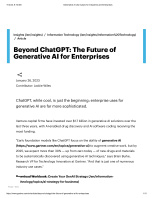
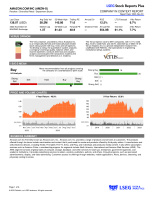
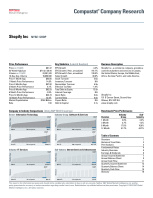
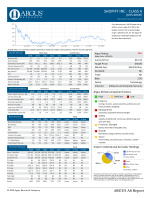
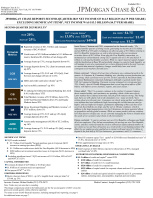
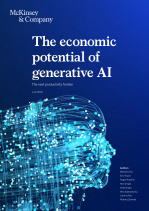
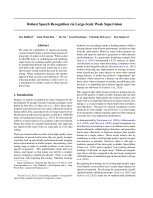

In [18]:
documents_t.show()

Although Pixeltable updates `documents` and `chunks`, it _doesn't_ automatically update the `queries` table in response. This is by design: we don't want 41 ChatGPT queries executing every time a single new document is added to the document base!

But if we ask the questions again, the answers will be run over the new, incrementally-updated index.

In [20]:
query_text = "What is JPMorgan's net income for the second quarter of 2023?"
top_5_chunks = (
    chunks_t.order_by(chunks_t.text.similarity(query_text), asc=False)
        .select(similarity=chunks_t.text.similarity(query_text), text=chunks_t.text)
        .limit(5)
    )
top_5_chunks.collect()

similarity,text
0.893188,"JPMORGAN CHASE REPORTS SECOND-QUARTER 2023 NET INCOME OF $14.5 BILLION ($4.75 PER SHARE)\nEXCLUDING SIGNIFICANT ITEMS2, NET INCOME WAS $13.3 BILLION ($4.37 PER SHARE)\nSECOND-QUARTER 2023 RESULTS1\nROE 20%\nROTCE2 25%\nCET1 Capital Ratios3\nStd. 13.8% | Adv. 13.9%\nTotal Loss-Absorbing Capacity3 $494B\nStd. RWA3 $1.7T \nCash and marketable securities4 $1.4T \nAverage loans $1.2T \nFirmwide \nMetrics\nn Reported revenue of $41.3 billion and managed \nrevenue of $42.4 billion2\nn Credit costs of $2.9 billion included a $1.5 billion net \nreserve build and $1.4 billion of net charge-offs\nn Average loans up 13%; average deposits down 6%\nCCB\nROE 38% \nn Average deposits down 2%; client investment assets \nup 42%\nn Average loans up 19% YoY and 15% QoQ; Card \nServices net charge-off rate of 2.41%\nn Debit and credit card sales volume5 up 7%\nn Active mobile customers6 up 10%\nCIB\n \n"
0.859738,"70 of the Firm's \n2022 Form 10-K.\nd.\nSecond-quarter 2023 net income, earnings per share and ROTCE excluding significant items are non-GAAP financial \nmeasures. Significant items collectively refer to the bargain purchase gain associated with First Republic of $2.7 billion, \nthe net credit reserve build associated with First Republic of $1.2 billion and net investment securities losses of $900 \nmillion. Excluding these significant items resulted in a decrease of $1.1 billion (after tax) to reported net income from \n$14.5 billion to $13.3 billion; a decrease of $0.38 per share to reported EPS from $4.75 to $4.37; and a decrease of 2% to \nROTCE from 25% to 23%. Management believes these measures provide useful information to investors and analysts in \nassessing the Firm's results.\nJPMorgan Chase & Co.\nNews Release \n6 \n Additional notes:\n3.\nEstimated. Reflects the Current Expected Credit Losses (""CECL"") capital transition provisions. Beginning January 1, 2022, \nthe $2.9 billion CECL capital benefit is being phased out at 25% per year over a three-year period. As of June 30, 2023, \nCET1 capital and Total Loss-Absorbing Capacity reflected the remaining $1.4 billion CECL benefit. Refer to Capital Risk \n"
0.857206,"ase.com \nInvestor Contact: Mikael Grubb (212) 270-2479\nNote: Totals may not sum due to rounding.\n1Percentage comparisons noted in the bullet points are for the second quarter of 2023 versus the \nprior-year second quarter, unless otherwise specified. \n2For notes on non-GAAP financial measures, including managed basis reporting, see page 6. \nFor additional notes see page 7.\nMedia Contact: Joseph Evangelisti (212) 270-7438\nIn the discussion below of Firmwide results of JPMorgan Chase & Co. (""JPMorgan Chase"" or the ""Firm""), information is \npresented on a managed basis, which is a non-GAAP financial measure, unless otherwise specified. The discussion below of the \nFirm's business segments is also presented on a managed basis. For more information about managed basis, and non-GAAP \nfinancial measures used by management to evaluate the performance of each line of business, refer to page 6.\nComparisons noted in the sections below are for the second quarter of 2023 versus the prior-year second quarter, unless \notherwise specified.\nJPMORGAN CHASE (JPM)\nResults for JPM\n1Q23\n2Q22\n($ millions, except per share data)\n2Q23\n1Q23\n2Q22\n$ O/(U)\nO/(U) %\n$ O/(U)\nO/(U)"
0.845293,"Prior-period amounts have been revised to \nconform with the current presentation.\n13. The bridge book consists of certain held-for-sale positions, including unfunded commitments, in CIB.\n14. Securitized Products Group is comprised of Securitized Products and Tax Oriented Investments.\nJPMorgan Chase & Co.\nNews Release \n7 \nJPMorgan Chase & Co. (NYSE: JPM) is a leading financial services firm based in the United States of America (""U.S.""), with \noperations worldwide. JPMorgan Chase had $3.9 trillion in assets and $313 billion in stockholders' equity as of June 30, 2023. \nThe Firm is a leader in inve

Let's force all the queries to run again by removing them from the `queries` table and re-inserting them as new rows. Notice how the structure of the tables and computed columns is preserved, even after we delete the existing data.

In [19]:
questions = list(queries_t.select(queries_t.S__No_, queries_t.Question, queries_t.correct_answer).collect())
queries_t.delete()
queries_t.insert(questions)

Computing cells: 100%|████████████████████████████████████████| 164/164 [00:59<00:00,  2.61 cells/s]
Inserting rows into `queries`: 41 rows [00:00, 1273.09 rows/s]
Computing cells: 100%|████████████████████████████████████████| 164/164 [00:59<00:00,  2.77 cells/s]
Inserted 41 rows with 0 errors.


UpdateStatus(num_rows=41, num_computed_values=164, num_excs=0, updated_cols=[], cols_with_excs=[])

In [21]:
queries_t.select(queries_t.Question, queries_t.correct_answer, queries_t.answer).show()

Question,correct_answer,answer
What is JPMorgan's net income for the second quarter of 2023 ?,$14.5 Billion,"JPMorgan's net income for the second quarter of 2023 was $14.5 billion, or $4.75 per share, excluding significant items."
What was the net income for the second quarter of 2023 for JP Morgan Asset & Wealth Management?,$ 1226 million,The net income for JP Morgan Asset & Wealth Management for the second quarter of 2023 was $1.2 billion.
What are the key communication equipments sector trends?,"Data demand is exploding because of mobile internet, video on the web, social","The key communication equipment sector trends mentioned in the passages include:\n\n1. Encroachment of computing and communications companies onto each other's turf, particularly in the enterprise data center.\n2. Significant market-share disruption and M&A activity driven by protocols such as FCoE (fibre channel over Ethernet) facilitating SAN-LAN convergence within data centers.\n3. Disruption in processing hegemony by ARM-based cores powering smartphones and tablet PCs, challenging traditional x86 architecture dominance.\n4. Transition from hard disk drive-based memory (HDD) to solid-state memory (SSD) in mobile computers.\n5. Competitive developments and advances in mobility driving demand for mobile devices and applications supplied by nontraditional players.\n6. Software power center shifting away from the data center towards public and private cloud networks serving enterprises, driven by developments such as collaboration, virtualization, cloud computing, SaaS, analytics, and interactivity."
What is the market capitalization for Infosys?,"$69,035.6 Million","The market capitalization for Infosys is $49,328.4 million."
What is the revenue for thoughtworks holding inc?,$ 1296.2 Million,The revenue for Thoughtworks Holding Inc (TWKS) is $965.0 million.
What is Shopify's 2020 Revenue?,$2.9 Billion,"Based on the provided information, Shopify's revenue for the year 2020 was $211.9 billion."
What JPMorgan's net income per share for second quarter of 2023 ?,$4.75 per share,JPMorgan's net income per share for the second quarter of 2023 was $4.75 per share.
What is the change in JPMorgan debit and credit card sales volume for second quarter of 2023?,The sales volume was up by 7 %,The change in JPMorgan debit and credit card sales volume for the second quarter of 2023 is an increase of 7%.
What was the net revenue reported for 2Q23 for JPMorgan Chase?,"$41, 307 Million",The net revenue reported for 2Q23 for JPMorgan Chase was $41.3 billion.
What was the net revenue reported for 2Q23 for JPM?,"$41, 307 Million",The net revenue reported for 2Q23 for JPMorgan Chase (JPM) was $41.3 billion.


Better!